In [17]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.metrics import ConfusionMatrixDisplay

sns.set_style('darkgrid')


In [18]:
DATASET_PATH = r"C:\Users\evilk\OneDrive\Desktop\III YEAR\LABS\DS\LAB3\AT&T dataset"
IMG_SIZE = (112, 92)

def load_dataset(directory=DATASET_PATH):
    images, labels = [], []
    for sub_id in range(1, 41):  
        sub_dir = os.path.join(directory, f"s{sub_id}")
        for img_id in range(1, 11):
            img_path = os.path.join(sub_dir, f"{img_id}.pgm")
            with Image.open(img_path) as img:
                images.append(np.array(img, dtype=np.uint8).flatten()) 
                labels.append(sub_id - 1)  
    return np.array(images), np.array(labels)

X, y = load_dataset()
print("Dataset shape:", X.shape, y.shape)


Dataset shape: (400, 10304) (400,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

print("Shape of X_train_std:", X_train_std.shape)
print("Shape of X_test_std:", X_test_std.shape)


Shape of X_train_std: (320, 10304)
Shape of X_test_std: (80, 10304)


In [33]:
# KNN on standardized data (no PCA)
knn_base = KNeighborsClassifier(n_neighbors=3)
knn_base.fit(X_train_std, y_train)

# Predictions
y_pred_base = knn_base.predict(X_test_std)

# Accuracy
accuracy_base = accuracy_score(y_test, y_pred_base)
print(f"Baseline Accuracy (no PCA): {accuracy_base*100:.2f}%\n")

# Classification report
print("--- Classification Report (No PCA) ---")
print(classification_report(y_test, y_pred_base))


Baseline Accuracy (no PCA): 91.25%

--- Classification Report (No PCA) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       0.50      0.50      0.50         2
           3       1.00      1.00      1.00         2
           4       0.50      0.50      0.50         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       0.67      1.00      0.80         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      0.50      0.67         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
      

In [20]:
# Covariance matrix
cov_matrix = np.cov(X_train_std, rowvar=False)

# Eigen decomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort in descending order
sorted_idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_idx]
eigenvectors = eigenvectors[:, sorted_idx]

print("Eigenvalues shape:", eigenvalues.shape)
print("Eigenvectors shape:", eigenvectors.shape)


Eigenvalues shape: (10304,)
Eigenvectors shape: (10304, 10304)


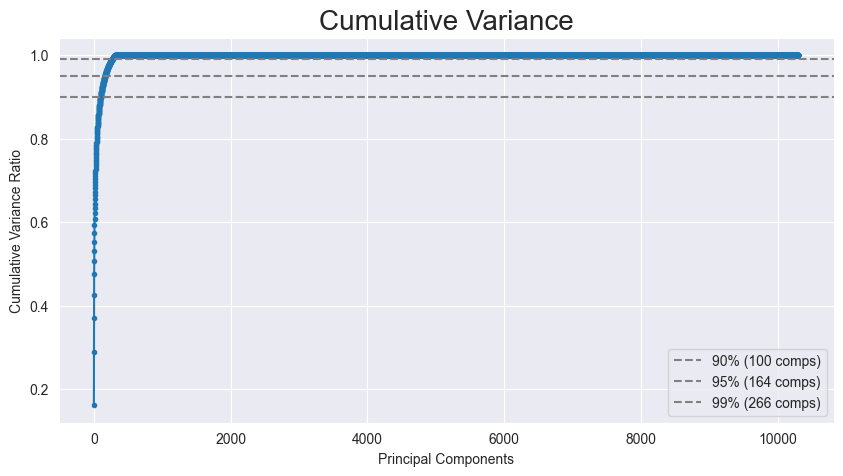

Best k (95% variance): 164


In [21]:
var_ratio = eigenvalues / np.sum(eigenvalues)
cum_var = np.cumsum(var_ratio)

plt.figure(figsize=(10,5))
plt.plot(range(1, len(cum_var)+1), cum_var, marker=".")
plt.title("Cumulative Variance", fontsize=20)
plt.xlabel("Principal Components")
plt.ylabel("Cumulative Variance Ratio")

for threshold in [0.9, 0.95, 0.99]:
    n_comp = np.argmax(cum_var >= threshold) + 1
    plt.axhline(y=threshold, color="gray", linestyle="--", label=f"{int(threshold*100)}% ({n_comp} comps)")
plt.legend()
plt.show()

best_k = np.argmax(cum_var >= 0.95) + 1
print(f"Best k (95% variance): {best_k}")


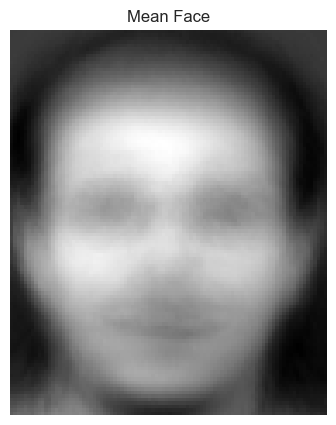

In [22]:
plt.figure(figsize=(5,5))
plt.imshow(scaler.mean_.reshape(IMG_SIZE), cmap='gray')
plt.title("Mean Face")
plt.axis('off')
plt.show()


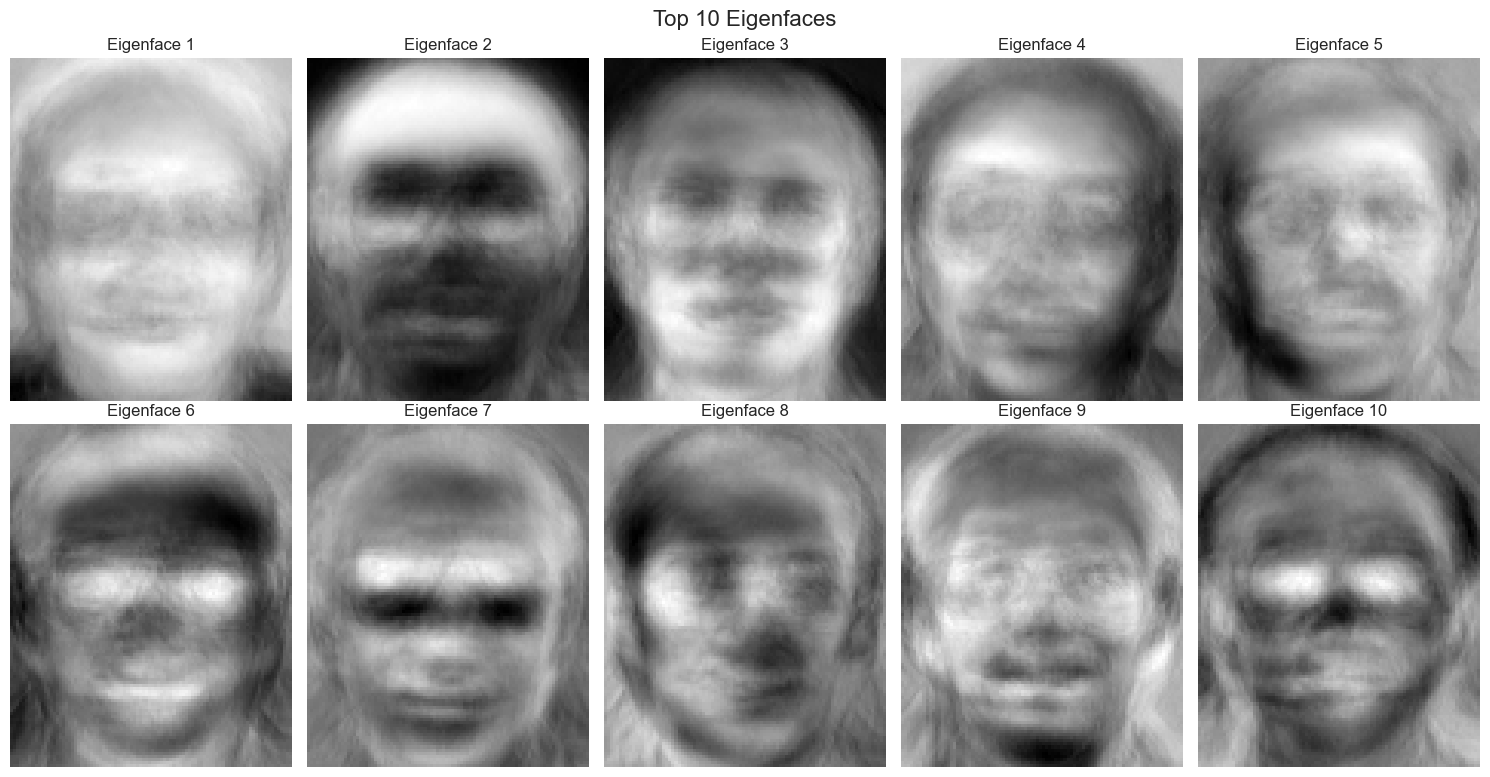

In [23]:
plt.figure(figsize=(15,8))
plt.suptitle("Top 10 Eigenfaces", fontsize=16)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(eigenvectors[:, i].reshape(IMG_SIZE), cmap='gray')
    plt.title(f"Eigenface {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Best k by accuracy: 30 components with accuracy: 92.50%


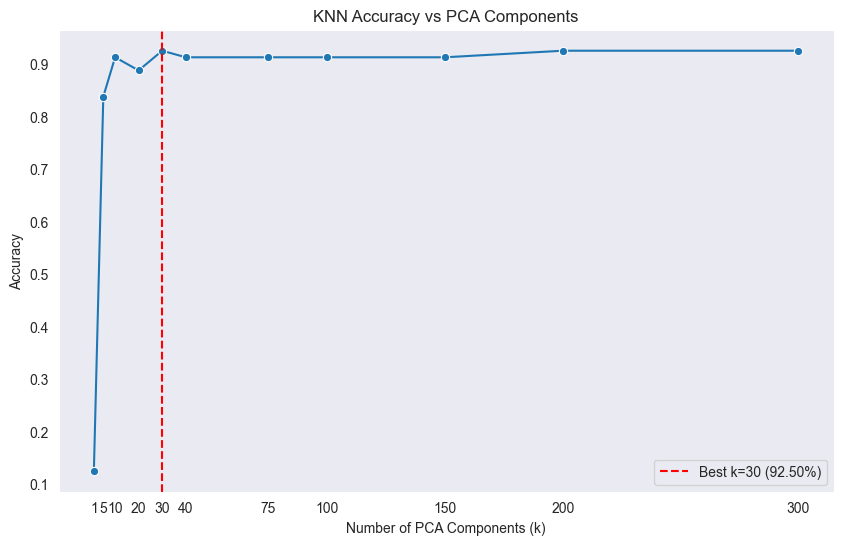

In [24]:
k_values = [1, 5, 10, 20, 30, 40, 75, 100, 150, 200, 300]
accuracies = []

for k in k_values:
    X_train_pca = X_train_std @ eigenvectors[:, :k]
    X_test_pca  = X_test_std  @ eigenvectors[:, :k]
    
    model = KNeighborsClassifier(n_neighbors=3).fit(X_train_pca, y_train)
    acc = accuracy_score(y_test, model.predict(X_test_pca))
    accuracies.append(acc)

best_idx = np.argmax(accuracies)
best_k_acc, best_acc = k_values[best_idx], accuracies[best_idx]

print(f"Best k by accuracy: {best_k_acc} components with accuracy: {best_acc*100:.2f}%")

plt.figure(figsize=(10,6))
sns.lineplot(x=k_values, y=accuracies, marker='o')
plt.axvline(x=best_k_acc, color="red", linestyle="--", label=f'Best k={best_k_acc} ({best_acc*100:.2f}%)')
plt.title("KNN Accuracy vs PCA Components")
plt.xlabel("Number of PCA Components (k)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.legend()
plt.grid()
plt.show()


In [25]:
X_train_best = X_train_std @ eigenvectors[:, :best_k]
X_test_best  = X_test_std  @ eigenvectors[:, :best_k]

final_knn = KNeighborsClassifier(n_neighbors=3)
final_knn.fit(X_train_best, y_train)
y_pred_best = final_knn.predict(X_test_best)

final_acc = accuracy_score(y_test, y_pred_best)
print(f"Final PCA+KNN accuracy with k={best_k}: {final_acc*100:.2f}%")

print("\n--- Classification Report (Final Model) ---")
print(classification_report(y_test, y_pred_best))


Final PCA+KNN accuracy with k=164: 91.25%

--- Classification Report (Final Model) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       0.50      0.50      0.50         2
           3       1.00      1.00      1.00         2
           4       0.50      0.50      0.50         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       0.67      1.00      0.80         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      0.50      0.67         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00     

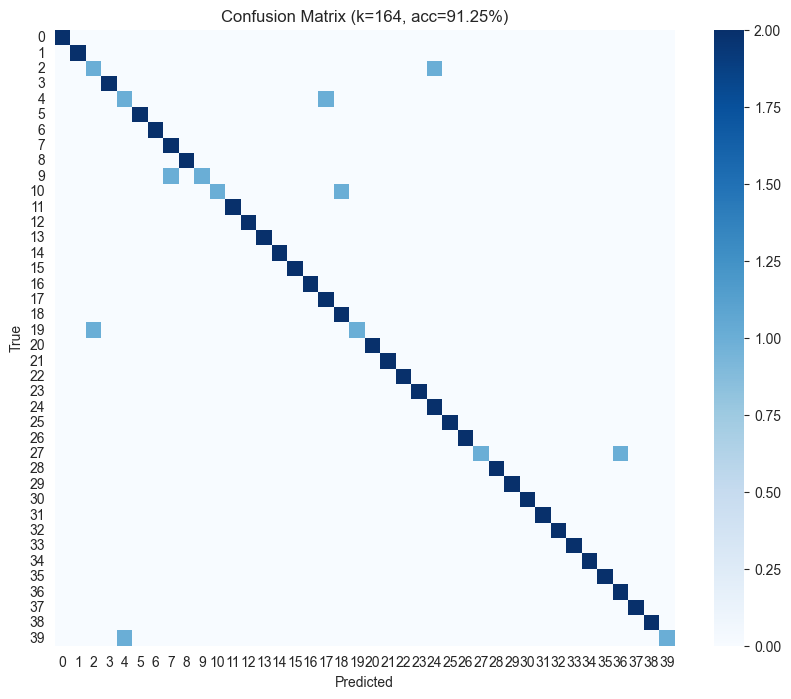

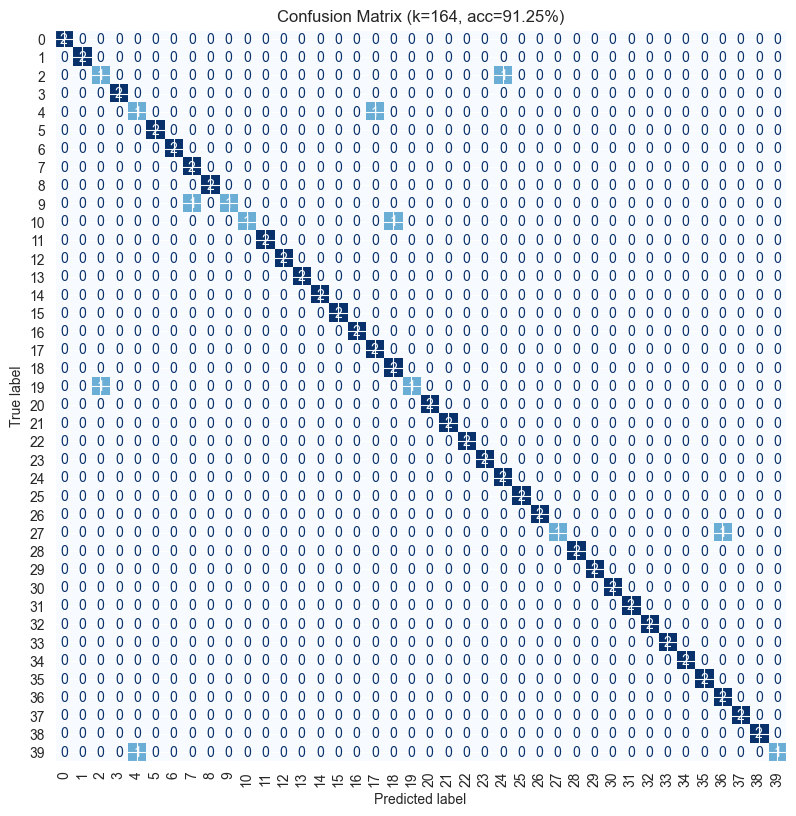

In [26]:
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues", cbar=True)
plt.title(f"Confusion Matrix (k={best_k}, acc={final_acc*100:.2f}%)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

fig, ax = plt.subplots(figsize=(10,9.5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=90, ax=ax, colorbar=False)
plt.title(f"Confusion Matrix (k={best_k}, acc={final_acc*100:.2f}%)")
plt.show()


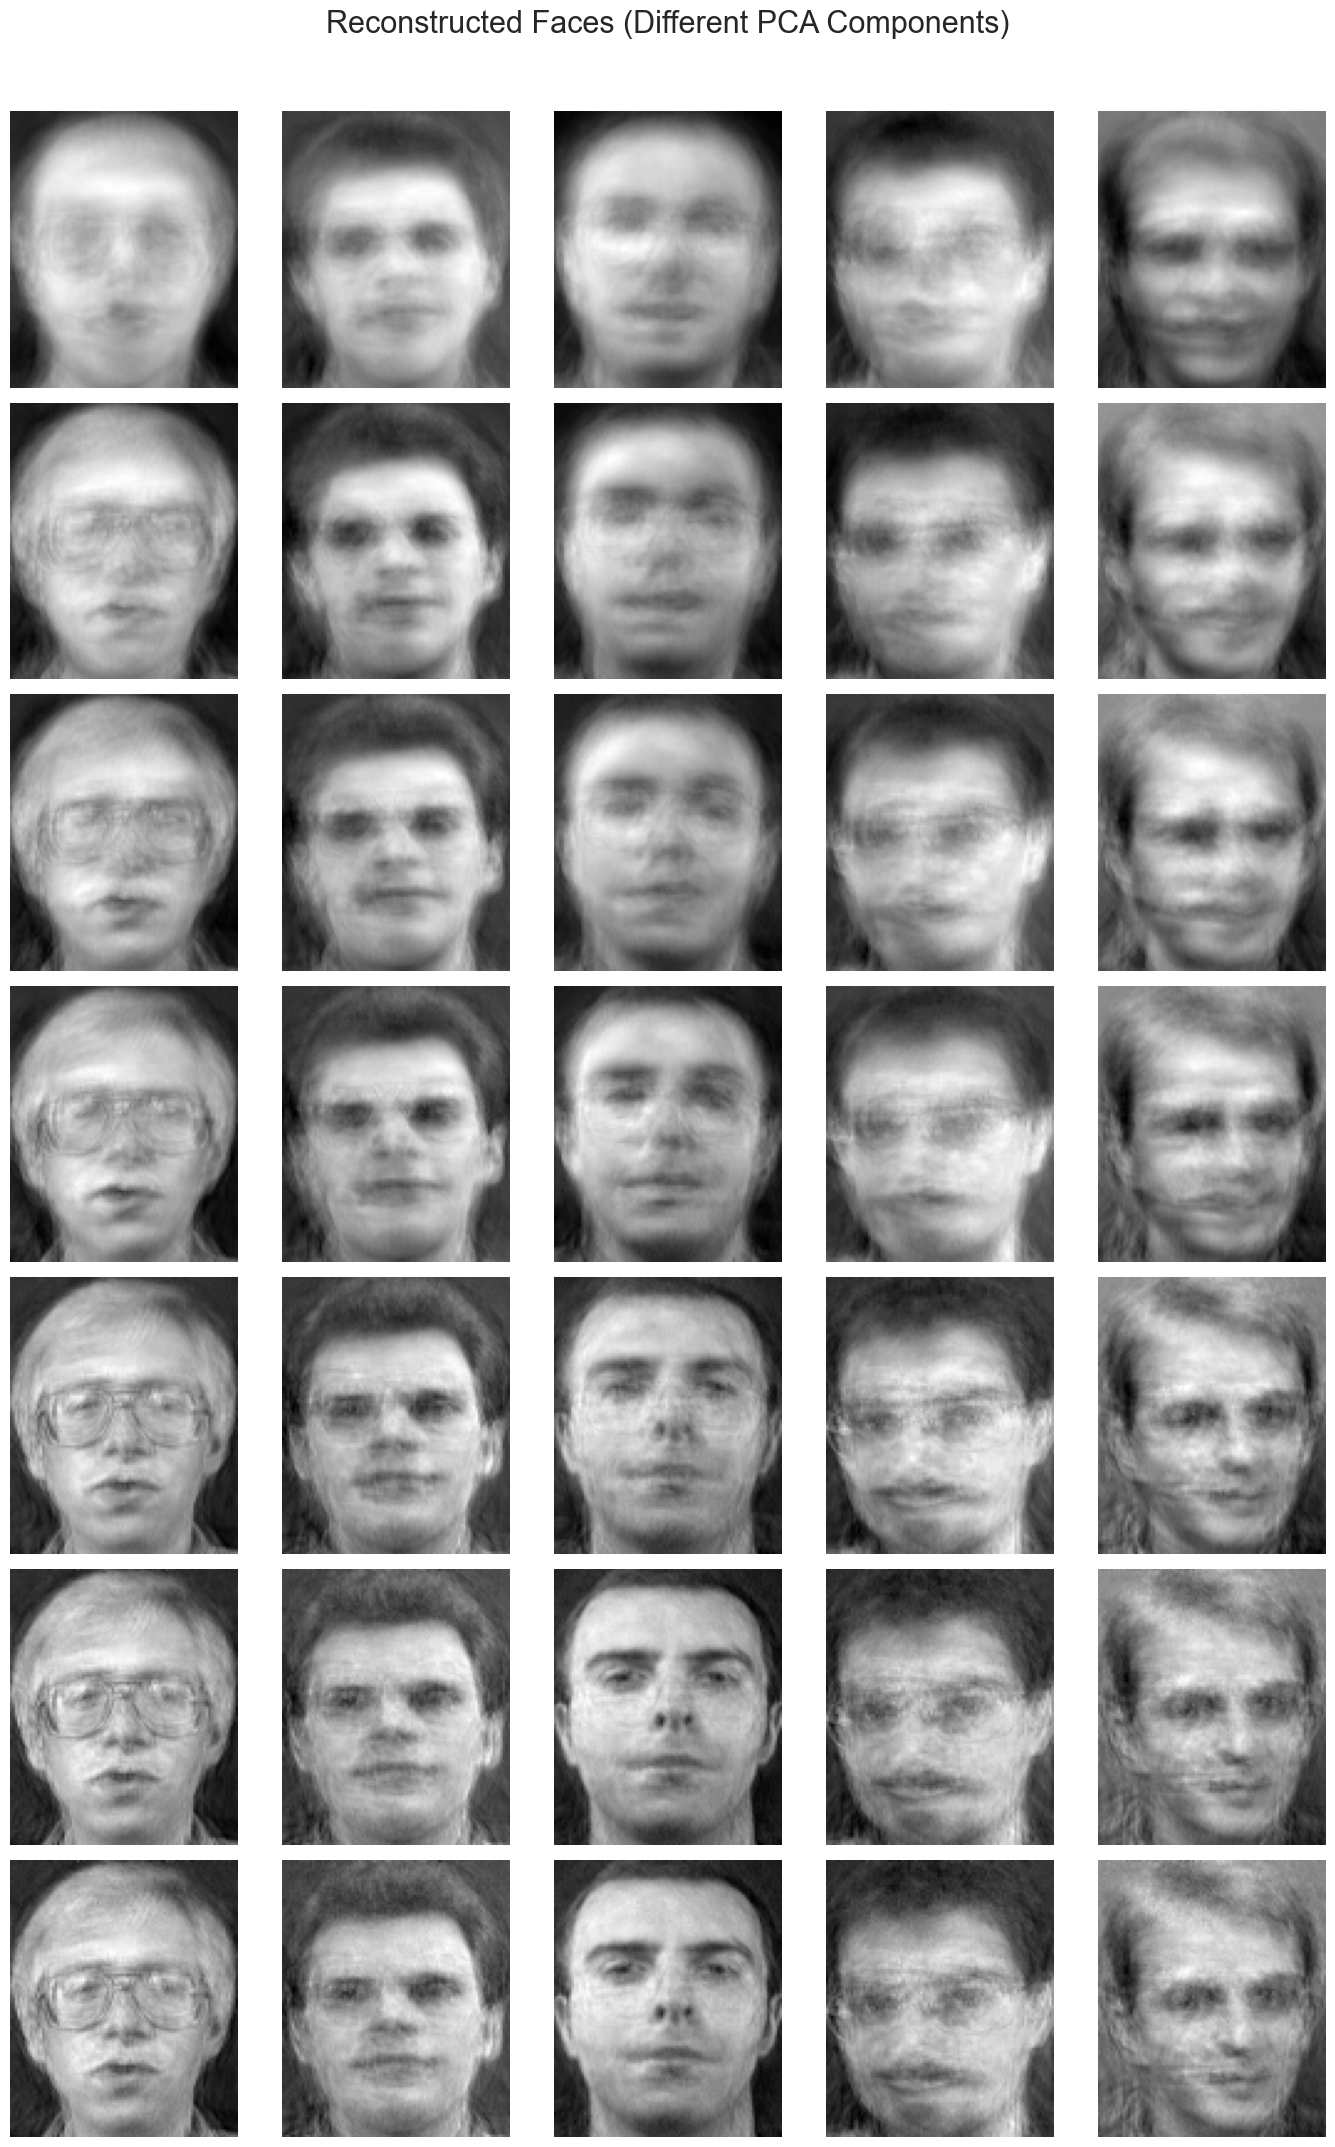

In [32]:
n_comp_list = [10, 20, 30, 50, best_k, 400, 500]

fig, axes = plt.subplots(len(n_comp_list), 5, figsize=(14, 3*len(n_comp_list)))

for i, n_comp in enumerate(n_comp_list):
    # Step 1: Project
    X_test_red = X_test_std @ eigenvectors[:, :n_comp]

    # Step 2: Reconstruct (standardized space)
    X_test_recon_std = X_test_red @ eigenvectors[:, :n_comp].T

    # Step 3: Undo standardization (back to original pixels)
    X_test_recon = X_test_recon_std * scaler.scale_ + scaler.mean_

    # Show first 5 reconstructed faces
    for j in range(5):
        axes[i, j].imshow(X_test_recon[j].reshape(IMG_SIZE), cmap="gray")
        axes[i, j].axis("off")

plt.suptitle("Reconstructed Faces (Different PCA Components)", fontsize=22, y=1.02)
plt.tight_layout()
plt.show()


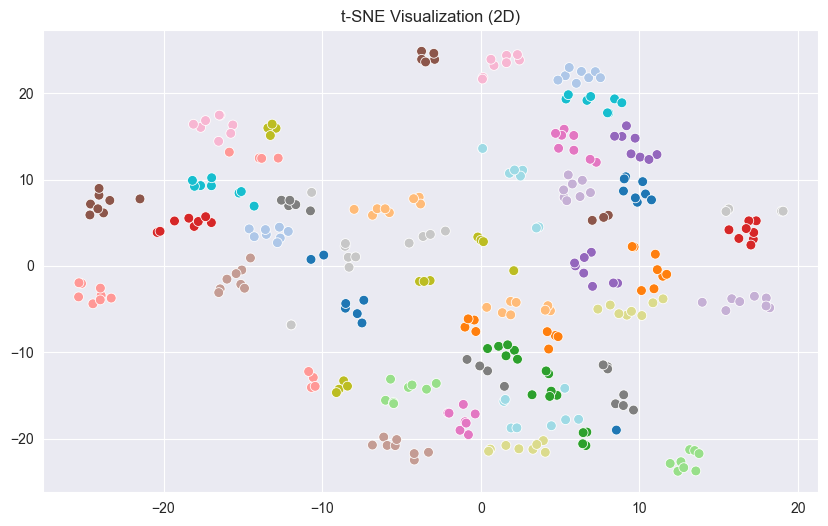

In [28]:
# Reduce before t-SNE (50 comps)
X_tsne_input = X_train_std @ eigenvectors[:, :50]

tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_2d = tsne_2d.fit_transform(X_tsne_input)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=y_train, palette="tab20", legend=False, s=50)
plt.title("t-SNE Visualization (2D)")
plt.show()


In [29]:
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, max_iter=1000)
X_3d = tsne_3d.fit_transform(X_tsne_input)

fig = px.scatter_3d(
    x=X_3d[:,0], y=X_3d[:,1], z=X_3d[:,2],
    color=y_train.astype(str),
    title="t-SNE Visualization (3D)", opacity=0.7
)
fig.update_layout(width=830, height=550)
fig.show()
